In [260]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
from tabulate import tabulate
import age_gender_predictor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import age_gender_predictor
import json
%matplotlib inline
from pylab import rcParams
from random import randint
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import vstack
rcParams['figure.figsize'] = 10, 7

In [261]:
def loads_LIWC():
    f = open("../4_prediction_visualization/categories.json", 'r')
    categories = json.load(f)
    f = open("../4_prediction_visualization/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                   
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories
LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC() 

In [137]:
# Data Fetching, transformation and filtering


def getLangRatio(cursor):
    lang_ratios = {}
    for tweet in cursor:
        lang = 1 if tweet["lang"] == "en" else 0
        user_id = tweet["user"]["id"]
        if user_id in lang_ratios:
            lang_ratios[user_id].append(lang)
        else:
            lang_ratios[user_id] = [lang]
    for user_id, ratio in lang_ratios.items():
        lang_ratios[user_id] = np.sum(ratio) / len(ratio)
    return lang_ratios
                                   

def getUsersTweets(dbName,collectionName, en_threshold=0.9):
    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    lang_ratios = getLangRatio(cursor)

    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    usersTweets = {}
    for tweet in cursor:
        userID = tweet["user"]["id"]
        if lang_ratios[userID] < en_threshold:
            continue
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersTweets:
            usersTweets[userID] = {}
        if date not in usersTweets[userID]:
            usersTweets[userID][date] = {}
            
        usersTweets[userID][date]['text'] = text
        usersTweets[userID][date]['polarity'] =  polarity
        usersTweets[userID][date]['emotion'] =  emotion
        usersTweets[userID][date]['emotion_2'] =  emotion_2
        usersTweets[userID][date]['ambiguous'] =  ambiguous
    return usersTweets



def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())


def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=100):    #Spam and inactive user filter
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group




In [190]:
class Group(object):
    
    
    
    def __init__(self, name, group=None, **kwargs):
        self.name = name

        dbName  = kwargs.get("dbName", None)
        collectionName  = kwargs.get("collectionName", None)
        
        if dbName is None or collectionName is None:
            self.group = group
        else:

            self.group = userFilter(timeSeriesTransform(getUsersTweets(dbName,collectionName)))
        
    def TweetsFrequency(self):
        
        
    def getTweetsFrequency(self):
        
        
    def getTexts(self):
        return ["\n".join(timeSeries["text"].values) for timeSeries in self.group]
    def getName(self):
        return self.name
    def getSize(self):
        return len(self.group)
    def __repr__(self):
        return repr(self.group)
    def __add__(self, other):
        return Group(self.name, self.group + other.group)
    
    
    def __iadd__(self, other):
        self.group += other.group
        return self    
    






BPD_group_clean = Group("BPD",dbName = "patients",collectionName="BPD_clean")
regular_group = Group("Random Samples",dbName = "idea",collectionName="regularUser_en_fixed_emotion")
bipolar_group_clean = Group("Bipolar",dbName ="patients", collectionName="bipolar_clean")
mix_group = Group("Mix", dbName = "patients",collectionName="bb_mix")


BPD_all = BPD_group_clean + mix_group
bipolar_all = bipolar_group_clean + mix_group


493 Normal and 284 Bipolar in Training Data
55 Normal and 32 Bipolar in Test Data

493 Normal and 217 BPD in Training Data
55 Normal and 24 BPD in Test Data



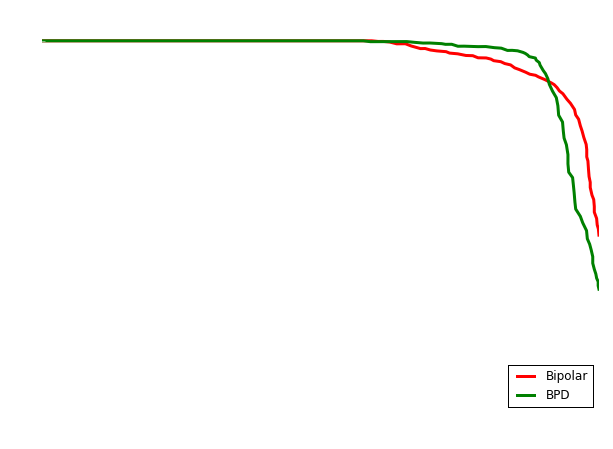

['mental illness', 'health', 'medication', 'depression http', 'mental', 'mentalhealth', 'helpful', 'hospital', 'health issues', 'meds', 'manic', 'depression', 'know feeling', 'effects', 'dealing', 'harm', 'help', 'depressive', 'cope', 'natasha_tracy', 'mindfulness', 'thoughts', 'diagnosed bipolar', 'ptsd', 'unstable', 'anxiety', 'psychiatrist', 'thanks', 'reading', 'suffering', 'supportive', 'living bipolar', 'game', 'triggered', 'hard time', 'illness', 'nurse_w_glasses', 'people bipolar', 'bipolar disorder', 'sorry hear', 'bipolardisorder', 'link', 'triggers', 'psychologist', 'insomnia', 'bipolarblogger', 'stigma', 'panic attacks', 'totally', 'keeping']
['disorder', 'anxiety', 'mental', 'suicidal', 'meds', 'personality', 'health', 'bpd', 'bit', 'patients', 'helps', 'trigger', 'bpdffs', 'diagnosis', 'try', 'therapy', 'psych', 'borderline', 'bpd http', 'triggers', 'blog', 'self', 'illness', 'selfharm', 'harm', 'thoughts', 'help', 'sufferers', 'girl_interrupt_', 'bpdchat', 'overwhelming'

In [259]:
#Tf-iDF performance, really robust



def XYGenerator(labeled_data):
    X, Y = labeled_data[0]
    

    
    for x, y in labeled_data[1:]:
        try:
            
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
   
    
    
    return X, Y


class TextFeatureGroups(object):
    
    def __init__(self, base, groups, model = "Tf-iDF"):
        self.base = base
        self.groups = groups
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
       
        base_texts = base.getTexts()
        self.text_models = []
        self.classifiers = []
        for group in groups:
            group_texts = group.getTexts()
            total_texts = base_texts  + group_texts
            if model == "Tf-iDF":
                text_model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
            text_model.fit(total_texts)    
            X = text_model.transform(total_texts)  
            Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
            classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X,Y)
            self.classifiers.append(classifier)
            self.text_models.append(text_model)
    
    
    def getTopFeatures(self, name, k=50):
        index = self.name_to_index[name]
        text_model = self.text_models[index]
        classifier = self.classifiers[index]
        feature_indicies = np.argsort(classifier.feature_importances_)
        vector2word = text_model.get_feature_names()
        top_words = []
        for i in range(k):
            vector = feature_indicies[-i-1]
            word = vector2word[vector]
            top_words.append(word)
        return top_words
            
            
        
        

    
    
    

    def getGroup(self,name):
        index = self.name_to_index[name]
        return self.group[index]
            
    def classify(self,name, group):
        index = self.name_to_index[name]
        classifier = self.classifiers[index]
        text_model = self.text_models[index]
        X = text_model.transform(group.getTexts())
        return classifier.predict(X) 
        
    
            
    def renderPrecisionRecall(self,colors=['r','g','b',"y","w"], n_fold = 30):
        classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')

        for g, group in enumerate(self.groups):

            SCORES = np.array([])
            LABELS = np.array([])
            
            
            X = self.text_models[g].transform(self.base.getTexts()+group.getTexts())
            Y =  np.zeros(self.base.getSize() + group.getSize(), dtype=int)
            Y[self.base.getSize():] = 1
            
            sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


            for train_index, test_index in sss:

                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))


            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


            print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,group.getName()))
            print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,group.getName()))
            plt.plot(recall, precision, label=group.getName() , color=colors[g],linewidth=3)

        plt.legend(loc="lower right")
        plt.show()

            
        
        
            
        

            
tfidf_groups = TextFeatureGroups(regular_group, [bipolar_all,BPD_all])
tfidf_groups.renderPrecisionRecall()
bipolar_words = tfidf_groups.getTopFeatures("Bipolar")
BPD_words = tfidf_groups.getTopFeatures("BPD")

print(bipolar_words)
print(BPD_words)



In [217]:
#Expert experiemnt of Tf-iDF kinda sucks
bipolar_experts =  Group("BPD", dbName= "patients", collectionName="bipolar_experts")
BPD_experts =  Group("bipolar", dbName="idea", collectionName="coach_tweets_emotion")



bipolar_result = tfidf_groups.classify("Bipolar", bipolar_experts)
BPD_result = tfidf_groups.classify("BPD", BPD_experts )






print("===== The Tf-iDF false positive experiment on disorder experts =====\n")

misclassified = np.sum(bipolar_result)
size = bipolar_experts.getSize()
name = bipolar_experts.getName()

print("{} out of {} {} experts are mis-calssified as patients. Accuracy {}".format(np.sum(bipolar_result), size, name, (size-misclassified)/size))
misclassified = np.sum(BPD_result)
size = BPD_experts.getSize()
name = BPD_experts.getName()
print("{} out of {} {} experts are mis-calssified as patients. Accuracy {}".format(np.sum(BPD_result), size, name, (size-misclassified)/size))





===== The Tf-iDF false positive experiment on disorder experts =====

9 out of 13 BPD experts are mis-calssified as patients. Accuracy 0.3076923076923077
10 out of 11 bipolar experts are mis-calssified as patients. Accuracy 0.09090909090909091


In [221]:
#Cross classification of Tf-iDF
#tfidf_groups_clean = TextFeatureGroups(regular_group, [bipolar_group_clean,BPD_group_clean])
#tfidf_groups_clean.renderPrecisionRecall()

bipolar_result = tfidf_groups_clean.classify("Bipolar", BPD_group_clean)
BPD_result = tfidf_groups_clean.classify("BPD", bipolar_group_clean)

#print(bipolar_result)
#print(BPD_result)




print("===== The cross-valadation experiment on disorder experts =====\n")

misclassified = np.sum(bipolar_result)
size = BPD_group_clean.getSize()
name = BPD_group_clean.getName()

print("{} out of {} {}  are mis-calssified as {} Accuracy {}".format(np.sum(bipolar_result), size, name, (size-misclassified)/size))
misclassified = np.sum(BPD_result)
size = bipolar_group_clean.getSize()
name = bipolar_group_clean.getName()
print("{} out of {} {}  are mis-calssified as {} Accuracy {}".format(np.sum(BPD_result), size, name, (size-misclassified)/size))







===== The cross-valadation experiment on disorder experts =====

142 out of 203 BPD experts are mis-calssified as patients. Accuracy 0.30049261083743845
152 out of 278 Bipolar experts are mis-calssified as patients. Accuracy 0.45323741007194246


In [5]:
#Individual pattern of life feature performance


class FeatureTransformer(object):
    def __init__(self, groups,groups_names):
        self.groups = groups
        self.groups_names = groups_names
        self.methods_mappper = {"hello":self.hello }
        self.total_texts = []
        for group in groups:
            for timeSeries in group:
                self.total_texts.append("\n".join(timeSeries["text"].value))

                
        
        
    def transform_by(self, method_names):
        sample_x = self.grpups[0][0]
        features_length = 0
    
        for method_name in method_names:
            

            
            method = self.methods_mappper[method_name]
            method()

def getLabledData(groups, methods):
    features = extractFeature(groups,methods)
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    return list(zip(features, Ylist)), feature_name



In [6]:
#Expert experiment to product best combinations of pol

In [ ]:
#Cross Classification of POL

In [29]:
#getText = lambda timeSeries : "\n".join(timeSeries["text"].str()
bipolar_groups[0][0]["text"].values[1]


"I'm going to be the bigger person and not talk about you, but just know I do truly hate you."

In [37]:
x = bipolar_groups[0][0]
x["text"].values += x["text"].values

AttributeError: can't set attribute

In [41]:
total_text = []
for group in bipolar_groups:
    for timeSeries in group:
        total_text.append("\n".join(timeSeries["text"].values))
        

model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
model.fit(total_text)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [46]:
x_text = bipolar_groups[0][0]["text"].values
model.transform(x_text)

<2035x5181435 sparse matrix of type '<class 'numpy.float64'>'
	with 24789 stored elements in Compressed Sparse Row format>

In [47]:
len(model.vocabulary_)

5181435

In [52]:
(a,b), c = (1,2),3

In [104]:
model.transform("Hello, hahahah")

<14x4634409 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [107]:
model.transform(["Hello\n, hahahah","Jesus Christ"])

<2x4634409 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [139]:
index

NameError: name 'index' is not defined

In [164]:
class myList(list):
    def __init__(self,a):
        self.data = a
    def __add__(self,other):
        return self.data + other.data
    
    def __repr__(self):
        return repr(self.data)

In [166]:
a  = myList([1,2,3])
b = myList([4,5,6])

In [169]:
a+=b

In [170]:
a

[1, 2, 3]

In [213]:
3

3

In [222]:
forest = RandomForestClassifier()


In [223]:
forest.feature_importances_

ValueError: Estimator not fitted, call `fit` before `feature_importances_`.

In [237]:
model.get_feature_names()

['00',
 '00 00',
 '00 00pm',
 '00 01',
 '00 03',
 '00 10',
 '00 11',
 '00 13',
 '00 15',
 '00 15am',
 '00 16',
 '00 1813673',
 '00 20',
 '00 200',
 '00 22',
 '00 23',
 '00 26',
 '00 28',
 '00 30',
 '00 37am',
 '00 3hr',
 '00 59',
 '00 7720852019',
 '00 99',
 '00 aaron_aof',
 '00 acc',
 '00 afraid',
 '00 afternoon',
 '00 alexanderson456',
 '00 alright',
 '00 amiright',
 '00 amp',
 '00 apply',
 '00 arrive',
 '00 atl',
 '00 backst',
 '00 bargin',
 '00 basketball',
 '00 bath',
 '00 beaviscumia',
 '00 bedtime',
 '00 beer',
 '00 believe',
 '00 best',
 '00 bet',
 '00 bethere',
 '00 bike',
 '00 birthday',
 '00 buy',
 '00 buyers',
 '00 bwi',
 '00 cancelled',
 '00 central',
 '00 cents',
 '00 cereal',
 '00 city',
 '00 class',
 '00 cleaning',
 '00 clock',
 '00 come',
 '00 concert',
 '00 corn',
 '00 coupon',
 '00 croix',
 '00 daily',
 '00 damn',
 '00 dawg',
 '00 day',
 '00 did',
 '00 dj',
 '00 doak',
 '00 donnadeegan',
 '00 dont',
 '00 douchebag',
 '00 downgrade',
 '00 draft',
 '00 drink',
 '00 dru

In [243]:
m = tfidf_groups.text_models[0]
c = tfidf_groups.classifiers[0]


In [246]:
vector2word = m.get_feature_names()
importance = c.feature_importances_

In [257]:
feature_indicies = np.argsort(importance)
vector2word[feature_indicies[-0]]

'00'